# A segurança alimentar no Ceará em 2024

João Victor Batista Lopes (IPECE - Instituto de Pesquisa e Estratégia Econômica do Ceará)

In [ ]:
library(devtools)

Carregando pacotes exigidos: usethis

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ purrr::set_names() masks magrittr::set_names()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Anexando pacote: 'srvyr'

O seguinte objeto é mascarado por 'package:stats':

    filter

        R/dados_svy_ce.R R/make_panel_san.R R/pnad2004.R R/pnad2009.R
value   ?                ?                  ?            ?           
visible FALSE            FALSE              FALSE        FALSE       
        R/pnad2013.R R/pnada_labeller.R R/pnadc.R R/pnadc_download.R R/pof.R
value   ?            ?                  ?         ?                  ?      
visible FALSE        FALSE              FALSE     FALSE              FALSE  
        R/pof_labeller.R R/read_pnada.R R/read_pof.R
value   ?                ?              ?           
visible FALSE            FALSE          FALSE       

## Introdução

This is a simple placeholder for the manuscript’s main document ([Knuth 1984](#ref-knuth84)).

## Evolução da prevalência de segurança e insegurança alimentar no Ceará

In [ ]:
dados <- readRDS("data/clean_data/painel_san.RDS")

In [ ]:
dados_svy <- dados[!is.na(dados$peso),] |> 
  filter(posicao=="Pessoa responsável") |> 
  as_survey_design(
    weights = peso,
    strata = estrato
  )

dados_svy |> 
  filter(posicao == "Pessoa responsável" & uf == "Ceará" & !is.na(san)) |>
  group_by(ano, san) |>
  summarise(
    n = survey_total(),
    proporcao = survey_mean()
  ) |>
  mutate(ano = fct_rev(ano),
         san=fct_rev(san)) |> 
  ggplot(aes(ano, proporcao, fill = san)) +
  geom_col(position = "stack") +
  coord_flip()+
  labs(
    title = "Evolução da prevalência de segurança alimentar e insegurança leve,\nmoderada e grave nos domicílios particulares permanentes",
    subtitle = "Ceará",
    y = "Proporção de domicílios",
    x = NULL,
    caption = "Fonte: PNAD Contínua/IBGE"
  ) +
  geom_text(
    aes(label = scales::percent(proporcao, accuracy = 0.1)), 
    vjust = -0.2, 
    position = position_stack(vjust = 0.5),
    size = 3,
    color ="white"
  ) +
  scale_y_continuous(
    labels = scales::percent,
    limits = c(0, NA)
  ) +
  scale_fill_manual(
    values = c("#e74c3c", "#e67e22", "#f39c12","#2ecc71"),
    name = "Situação de Segurança Alimentar",
    labels = c("IA grave", "IA moderada", "IA leve","Segurança alimentar")
  )+
  guides(fill = guide_legend(reverse = TRUE)) +
  theme_minimal(base_size = 11) +
  theme(
    legend.position = "bottom",
    legend.direction = "horizontal",
    legend.title.position = "top",
    legend.title = element_text(face = "bold", size = 10),
    legend.text = element_text(size = 8),
    strip.text = element_text(face = "bold", size = 6),
    strip.background = element_rect(fill = "grey90", color = NA),
    plot.title = element_text(hjust = 0.5, face = "bold", size = 13),
    plot.subtitle = element_text(hjust = 0.5, size = 11),
    plot.caption = element_text(hjust = 0, size = 9, color = "grey40"),
    panel.grid.major.y = element_blank(),
    panel.grid.minor = element_blank(),
    axis.text.y = element_text(size = 10)
  )

## Situação de segurança alimentar no ceará e recortes geográficos

In [ ]:
bind_rows(
  dados |> 
    filter(ano %in% c("PNADC 2023", "PNADC 2024") & posicao == "Pessoa responsável" & uf == "Ceará") |>
    count(ano, san, situacao, wt=peso) |>
    mutate(Tipo = "Domicílios"),
  dados |> 
    filter(ano %in% c("PNADC 2023", "PNADC 2024") & uf == "Ceará") |>
    count(ano, san, situacao, wt=peso) |>
    mutate(Tipo = "Moradores")
) |>
  mutate(n = n/1000) |>
  pivot_wider(names_from = c(Tipo, situacao), 
              values_from = n,
              names_glue = "{Tipo}_{situacao}") |>
  mutate(`Domicílios_Total` = `Domicílios_Urbana` + `Domicílios_Rural`, .after = `Domicílios_Urbana`) |> 
  mutate(`Moradores_Total` = `Moradores_Urbana` + `Moradores_Rural`, .after = `Moradores_Urbana`) |>
  group_by(ano) |>
  gt() |>
  tab_header(
    title = "Insegurança Alimentar no Ceará (em milhares)",
    subtitle = "Ceará – 2023 e 2024"
    ) |>
  tab_spanner(label = "Domicílios", columns = starts_with("Domicílios")) |>
  tab_spanner(label = "Moradores", columns = starts_with("Moradores")) |>
  cols_label(
    san = "Categoria",
    `Domicílios_Urbana` = "Urbana",
    `Domicílios_Rural` = "Rural",
    `Domicílios_Total` = "Total",
    `Moradores_Urbana` = "Urbana",
    `Moradores_Rural` = "Rural",
    `Moradores_Total` = "Total"
  ) |>
  fmt_number(decimals = 0, locale = "pt") |>
  tab_style(
    style = list(cell_fill(color = "#E3F2FD"), cell_text(weight = "bold")),
    locations = cells_body(columns = c(`Domicílios_Total`, `Moradores_Total`))
    ) |>
  tab_style(
    style = cell_text(weight = "bold", align = "center"),
    locations = cells_row_groups()
  ) |> 
  # Fonte da tabela
  tab_source_note(source_note = "Fonte: PNAD Contínua/IBGE") |>
  # Tema geral
  tab_options(
    table.font.size = px(12),
    heading.align = "center",
    column_labels.font.weight = "bold",
    source_notes.font.size = px(10),
    row_group.background.color = "#1976D2",
    heading.background.color = "#0D47A1"
  )

In [ ]:
# Paleta de cores
paleta_san <- scale_fill_manual(
  values = c("#2ecc71", "#f39c12", "#e67e22", "#e74c3c"),
  name = "Situação de Segurança Alimentar",
  labels = c("Segurança alimentar", "IA leve", "IA moderada", "IA grave")
)

# As vezes precisa dela invertida
paleta_san_invertida <- scale_fill_manual(
    values = c("#e74c3c", "#e67e22", "#f39c12","#2ecc71"),
    name = "Situação de Segurança Alimentar",
    labels = c("IA grave", "IA moderada", "IA leve","Segurança alimentar")
  )

# Eixo Y padrão
eixo_y_percentual <- scale_y_continuous(
  labels = scales::percent,
  limits = c(0, NA)
)

# Tema customizado
tema_san <- theme_minimal(base_size = 11) +
  theme(
    legend.position = "bottom",
    legend.direction = "horizontal",
    legend.title.position = "top",
    legend.title = element_text(face = "bold", size = 10),
    strip.text = element_text(face = "bold", size = 11),
    strip.background = element_rect(fill = "grey90", color = NA),
    plot.title = element_text(hjust = 0.5, face = "bold", size = 13),
    plot.subtitle = element_text(hjust = 0.5, size = 11),
    plot.caption = element_text(hjust = 0, size = 9, color = "grey40"),
    panel.grid.major.x = element_blank(),
    panel.grid.minor = element_blank(),
    axis.text.x = element_text(size = 10)
  )

In [ ]:
dados_svy_ce(dados, situacao) |> 
  ggplot(aes(fct_rev(ano), proporcao, fill = fct_rev(san))) +
  geom_col(position = "stack", width = 0.7) +
  coord_flip()+
  facet_grid(situacao ~ ., 
             labeller = labeller(situacao = c(Urbana = "Área Urbana", 
                                            Rural = "Área Rural")))+
  geom_text(
    aes(label = scales::percent(proporcao, accuracy = 0.1)), 
    position = position_stack(vjust = 0.7),
    size = 3,
    color="white")+
  labs(
    title = "Domicílios particulares, por situação de segurança alimentar,\nsegundo a situação do domicílio",
    subtitle = "Ceará – 2023 e 2024",
    y = "Proporção de domicílios",
    x = NULL,
    caption = "Fonte: PNAD Contínua/IBGE"
  )+
  paleta_san_invertida +
  guides(fill = guide_legend(reverse = TRUE)) +
  eixo_y_percentual +
  tema_san

In [ ]:
dados |> 
  dados_svy_ce(estrato) |> 
  filter(ano=="PNADC 2024") |> 
  mutate(estrato = fct_recode(estrato, 
                              "Fortaleza(CE)" = "2310",
                              "Entorno metropolitano \nde Fortaleza (CE)" = "2320",
                              "Litoral Ocidental \ne Norte do Ceará"= "2353",
                              "Litoral Oriental \nVale do R. Jaguaribe (CE)"="2354",
                              "Sertões do Ceará"="2352",
                              "Sul do Ceará"="2351")) |> 
  ggplot(aes(fct_rev(estrato), proporcao, fill = fct_rev(san))) +
  geom_col(position = "stack", width = 0.7) +
  coord_flip()+
  labs(
    title = "Percentual de domicílios particulares permanentes por situação de segurança alimentar, segundo os recortes geográficos",
    subtitle = "Ceará – 2024",
    y = "Proporção de domicílios",
    x = NULL,
    caption = "Fonte: PNAD Contínua/IBGE"
  ) +
  geom_text(
    aes(label = scales::percent(proporcao, accuracy = 0.1)), 
    position = position_stack(vjust = 0.5),
    size = 3,
    color="white"
  ) +
  paleta_san_invertida +
  guides(fill = guide_legend(reverse = TRUE)) +
  eixo_y_percentual +
  tema_san

## Situação de segurança alimentar: comparação Brasil, Nordeste e Ceará

In [ ]:
indicadores <- dados |> 
  filter(ano == "PNADC 2024" & posicao == "Pessoa responsável" & !is.na(peso)) |> 
  mutate(
    # Região
    regiao = case_when(
      uf %in% c("Maranhão", "Piauí", "Ceará", "Rio Grande do Norte",
                "Paraíba", "Pernambuco", "Alagoas", "Sergipe", "Bahia") ~ "Nordeste",
      TRUE ~ "Outras"
    )) |> 
  filter(uf == "Ceará" | regiao == "Nordeste") |>
  mutate(grupo = case_when(
    uf == "Ceará" ~ "Ceará",
    regiao == "Nordeste" ~ "Nordeste",
    TRUE ~ NA_character_)) |>
  as_survey_design(weights = peso) |> 
  group_by(grupo, san) |>
  summarise(
      n = survey_total(),
      .groups = "drop"
    ) |>
  group_by(grupo) |>
  mutate(
      populacao = sum(n),
      proporcao = n / populacao
    ) |>
  ungroup()

brasil <- dados |> 
  filter(ano == "PNADC 2024" & posicao == "Pessoa responsável" & !is.na(peso)) |> 
  as_survey_design(weights = peso) |> 
  group_by(san) |>
  summarise(
    grupo="Brasil",
    n = survey_total(),
    .groups = "drop"
    ) |>
  group_by(grupo) |>
  mutate(
      populacao = sum(n),
      proporcao = n / populacao
    ) |>
  ungroup()

indicadores <- bind_rows(indicadores, brasil)

In [ ]:
indicadores |> 
  mutate(grupo = fct_relevel(grupo, "Ceará", "Nordeste", "Brasil")) |> 
  ggplot(aes(fct_rev(grupo), proporcao, fill = fct_rev(san))) +
  geom_col(position = "stack", width = 0.7) +
  coord_flip()+
  labs(
    title = "Domicílios particulares, por situação de segurança alimentar,\nsegundo o sexo da pessoa responsável pelo domicílio",
    subtitle = "Brasil, Nordeste e Ceará – 2024",
    y = "Proporção de domicílios",
    x = NULL,
    caption = "Fonte: PNAD Contínua/IBGE"
  ) +
  geom_text(
    aes(label = scales::percent(proporcao, accuracy = 0.1)), 
    position = position_stack(vjust = 0.5),
    size = 3,
    color="white"
  ) +
  paleta_san_invertida +
  guides(fill = guide_legend(reverse = TRUE)) +
  eixo_y_percentual +
  tema_san

## Características dos domicílios e de seus moradores

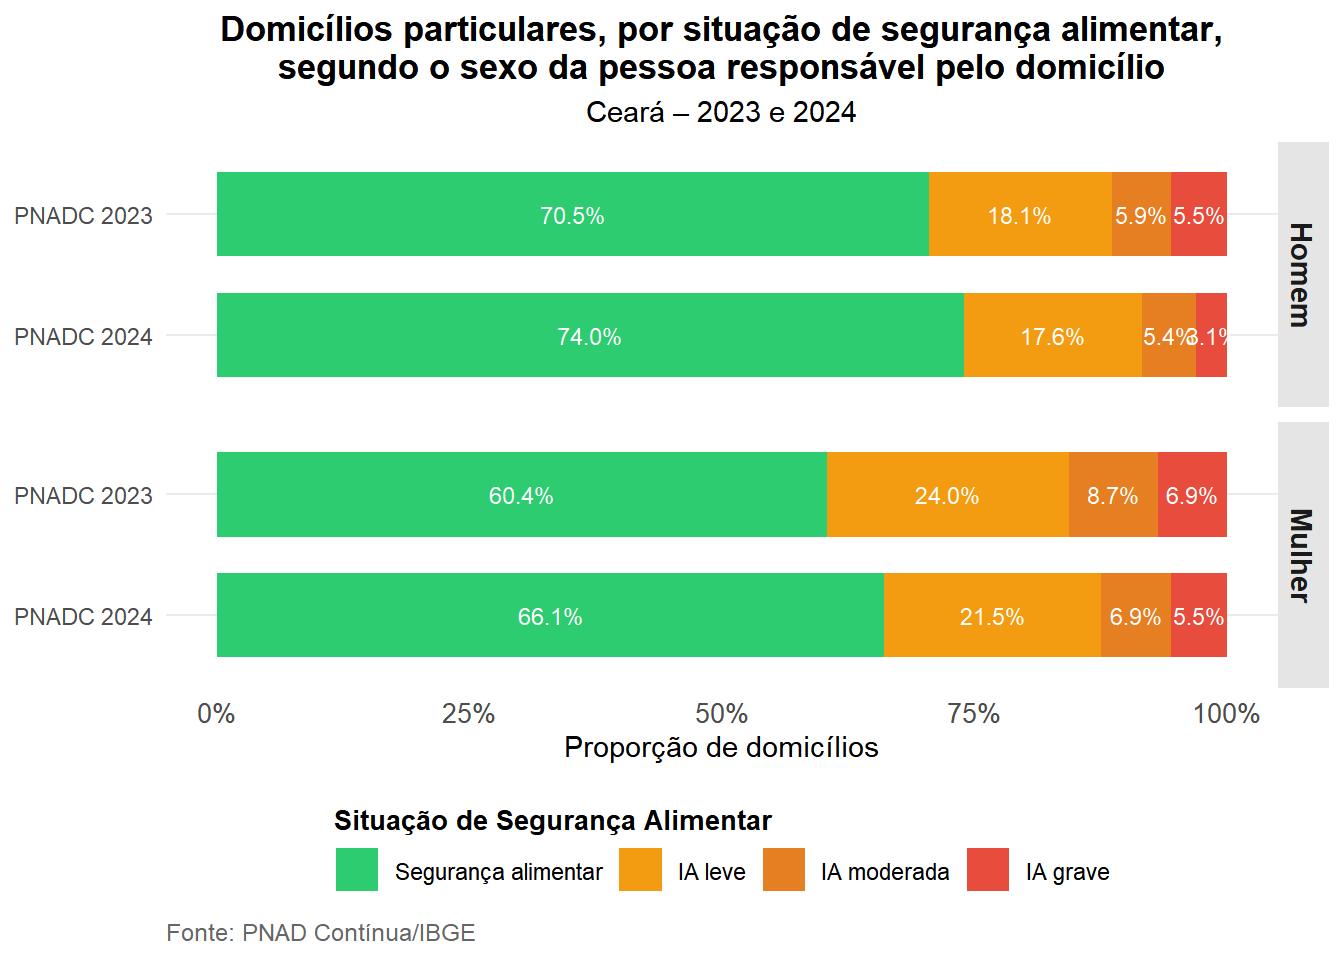

In [ ]:
dados_svy_ce(dados, sexo) |> 
  ggplot(aes(fct_rev(ano), proporcao, fill = fct_rev(san))) +
  geom_col(position = "stack", width = 0.7) +
  coord_flip()+
  facet_grid(sexo ~ .)+
  labs(
    title = "Domicílios particulares, por situação de segurança alimentar,\nsegundo o sexo da pessoa responsável pelo domicílio",
    subtitle = "Ceará – 2023 e 2024",
    y = "Proporção de domicílios",
    x = NULL,
    caption = "Fonte: PNAD Contínua/IBGE"
  ) +
  geom_text(
    aes(label = scales::percent(proporcao, accuracy = 0.1)), 
    position = position_stack(vjust = 0.5),
    size = 3,
    color="white"
  ) +
  paleta_san_invertida +
  guides(fill = guide_legend(reverse = TRUE)) +
  eixo_y_percentual +
  tema_san

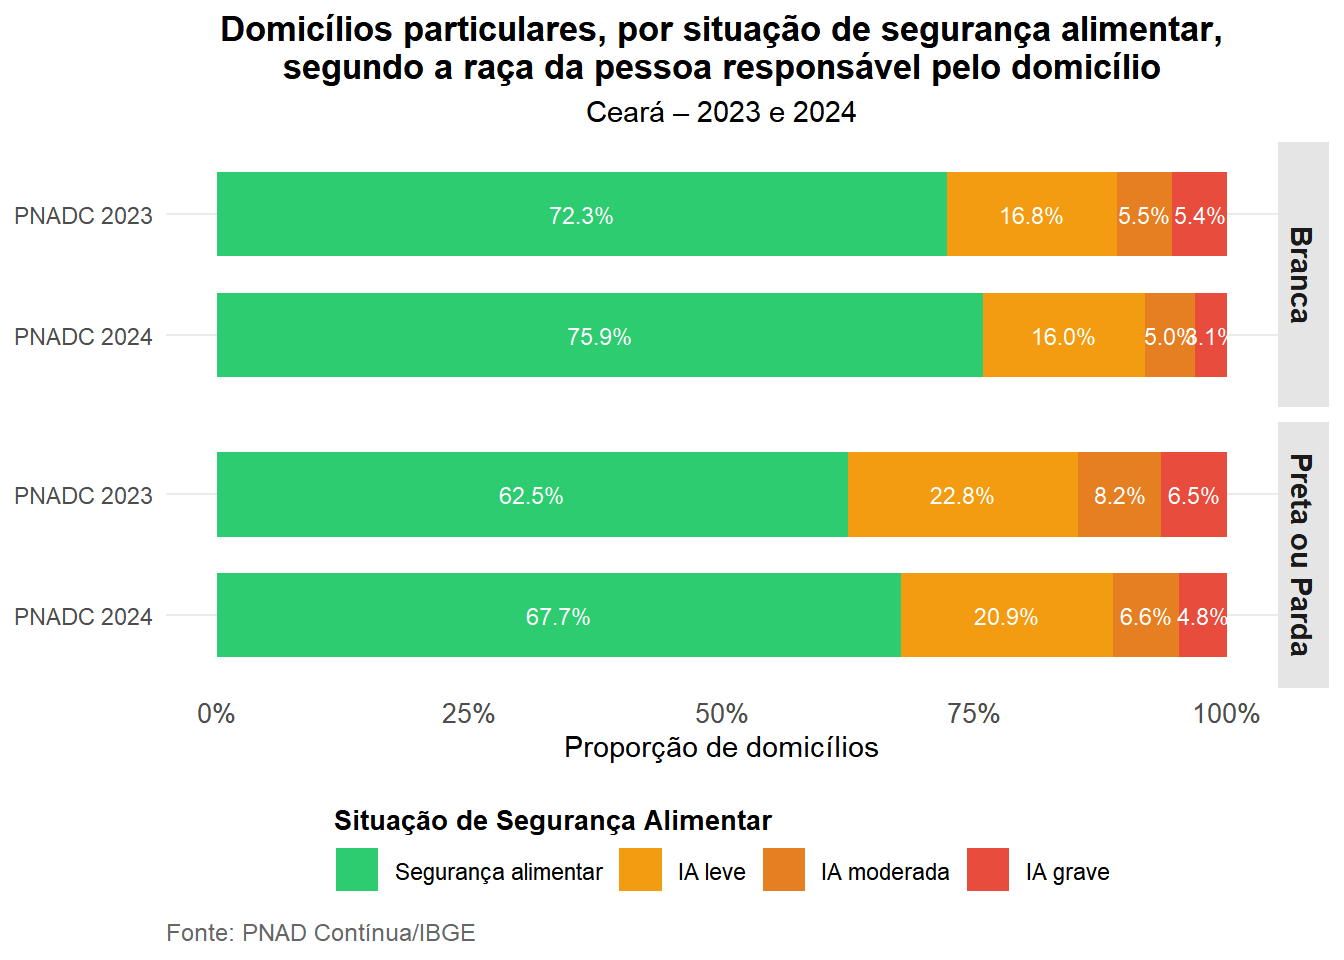

In [ ]:
dados |>
  mutate(
    raca = case_when(
      raca == "Branca" ~ "Branca",
      raca == "Preta" ~ "Preta ou Parda",
      raca == "Parda" ~ "Preta ou Parda",
      TRUE ~ "Outras"
    )
  ) |> 
  dados_svy_ce(raca) |> 
  filter(raca %in% c("Branca", "Preta ou Parda")) |> 
  ggplot(aes(fct_rev(ano), proporcao, fill = fct_rev(san))) +
  geom_col(position = "stack", width = 0.7)+
  coord_flip()+
  facet_grid(raca ~ .) +
  labs(
    title = "Domicílios particulares, por situação de segurança alimentar,\nsegundo a raça da pessoa responsável pelo domicílio",
    subtitle = "Ceará – 2023 e 2024",
    y = "Proporção de domicílios",
    x = NULL,
    caption = "Fonte: PNAD Contínua/IBGE"
  ) +
  geom_text(
    aes(label = scales::percent(proporcao, accuracy = 0.1)), 
    position = position_stack(vjust = 0.5),
    size = 3,
    colour="white"
  ) +
  paleta_san_invertida +
  guides(fill = guide_legend(reverse = TRUE)) +
  eixo_y_percentual +
  tema_san

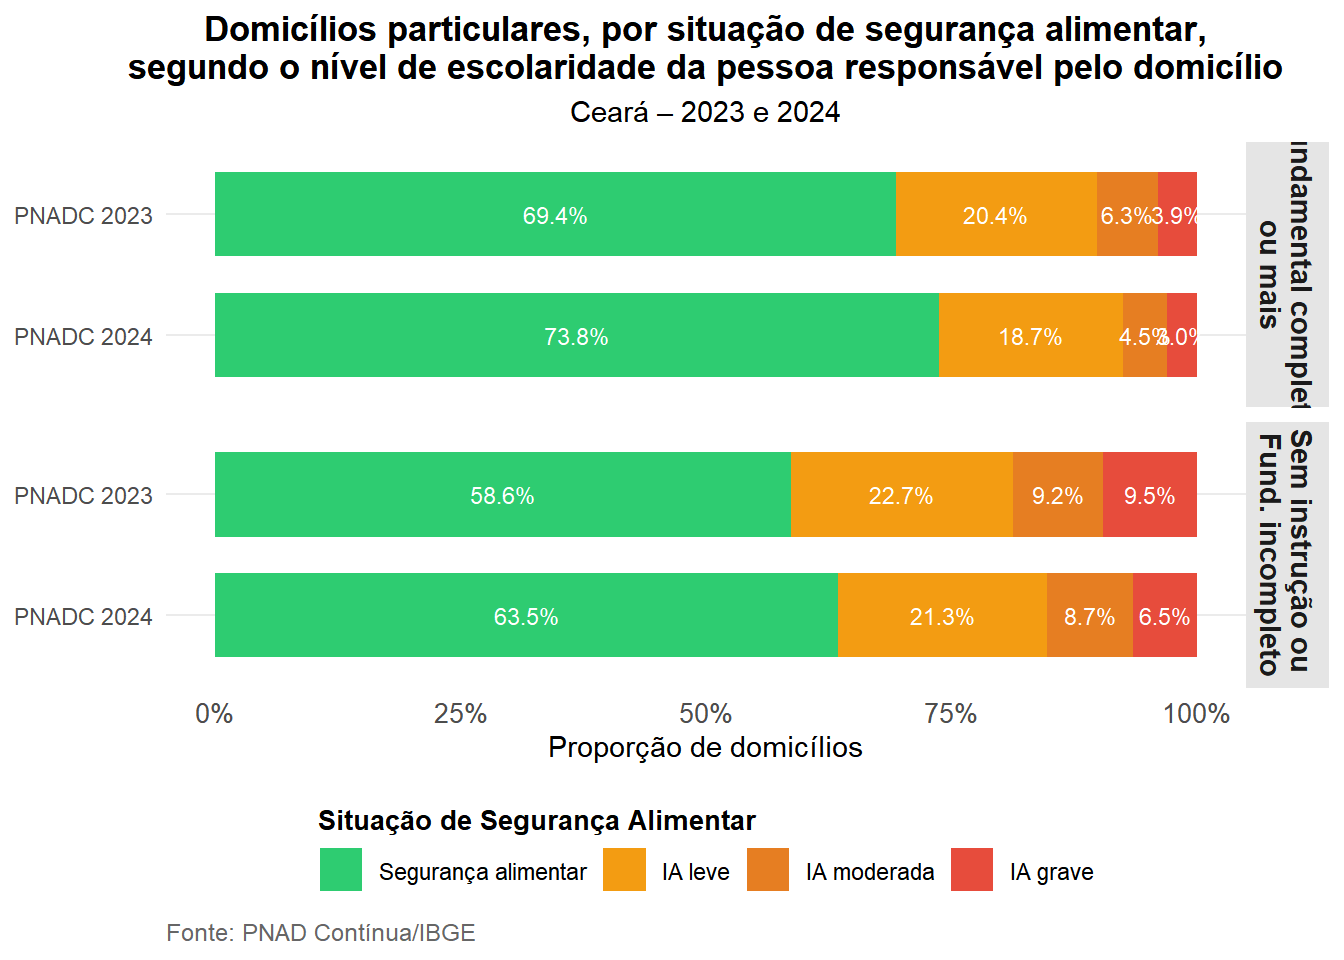

In [ ]:
dados |>
  mutate(
    faixa_escolaridade = case_when(
      faixa_escolaridade == "Sem instrução e menos de 1 ano de estudo" ~ "Sem instrução ou \nFund. incompleto",
      faixa_escolaridade == "Fundamental incompleto ou equivalente" ~ "Sem instrução ou \nFund. incompleto",
      TRUE ~ "Fundamental completo \nou mais"
    )) |> 
  dados_svy_ce(faixa_escolaridade) |> 
  ggplot(aes(fct_rev(ano), proporcao, fill = fct_rev(san))) +
  geom_col(position = "stack", width = 0.7)+
  coord_flip()+
  facet_grid(faixa_escolaridade ~ .) +
  labs(
    title = "Domicílios particulares, por situação de segurança alimentar,\nsegundo o nível de escolaridade da pessoa responsável pelo domicílio",
    subtitle = "Ceará – 2023 e 2024",
    y = "Proporção de domicílios",
    x = NULL,
    caption = "Fonte: PNAD Contínua/IBGE"
  ) +
  geom_text(
    aes(label = scales::percent(proporcao, accuracy = 0.1)), 
    position = position_stack(vjust=0.5),
    size = 3,
    colour="white"
  ) +
  paleta_san_invertida +
  guides(fill = guide_legend(reverse = TRUE)) +
  eixo_y_percentual +
  tema_san

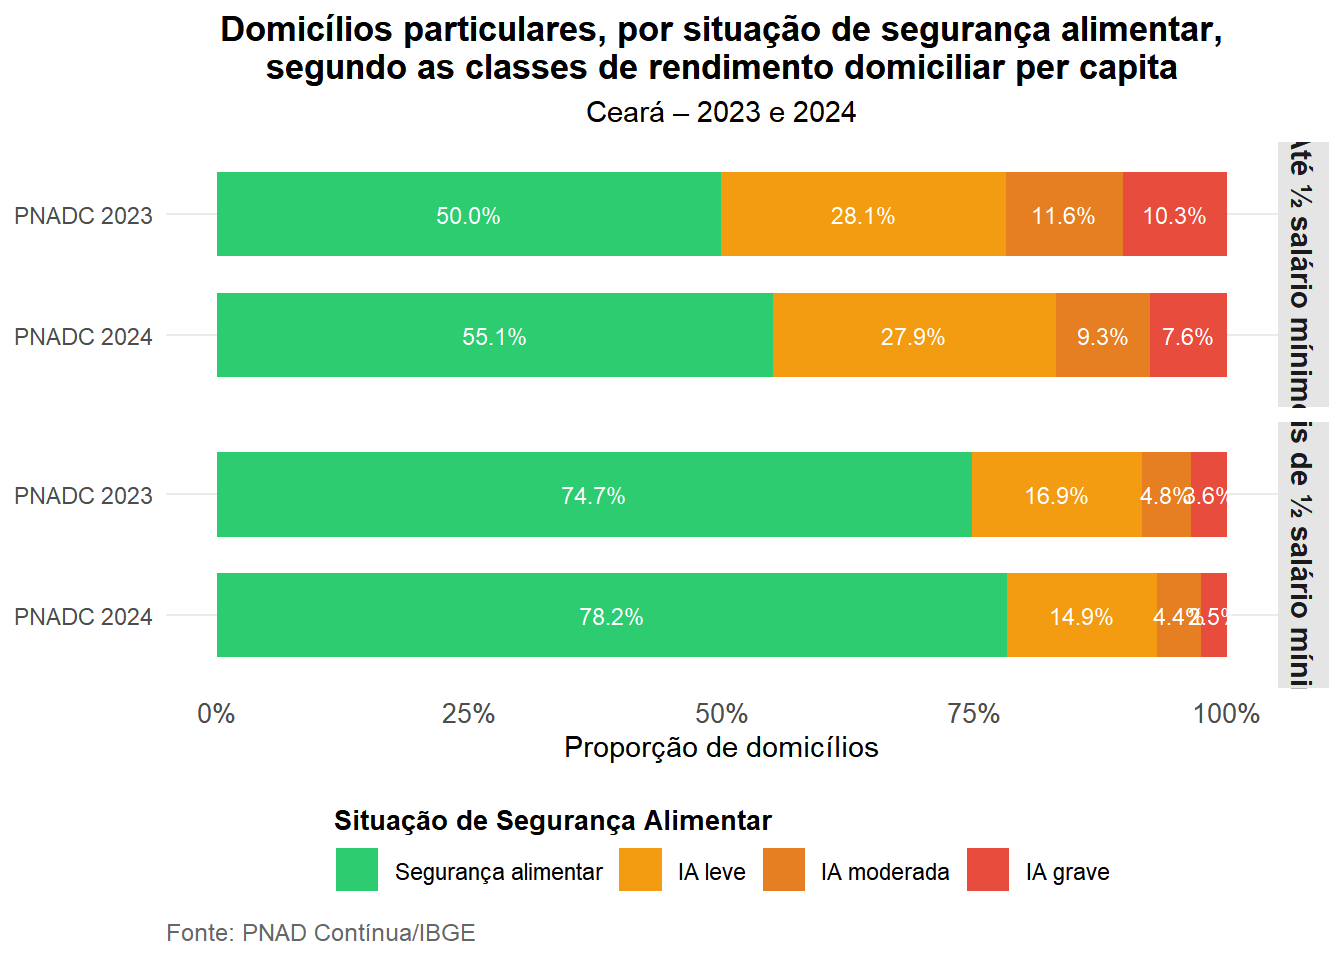

In [ ]:
dados |>
  mutate(
    faixa_renda = case_when(
      faixa_renda == "Até ¼ salário mínimo" ~ "Até ½ salário mínimo",
      faixa_renda == "Mais de ¼ até ½ salário mínimo" ~ "Até ½ salário mínimo",
      TRUE ~ "Mais de ½ salário mínimo"
    )) |> 
  dados_svy_ce(faixa_renda) |> 
  ggplot(aes(fct_rev(ano), proporcao, fill = fct_rev(san))) +
  geom_col(position = "stack", width = 0.7)+
  coord_flip()+
  facet_grid(faixa_renda ~ .) +
  labs(
    title = "Domicílios particulares, por situação de segurança alimentar,\nsegundo as classes de rendimento domiciliar per capita",
    subtitle = "Ceará – 2023 e 2024",
    y = "Proporção de domicílios",
    x = NULL,
    caption = "Fonte: PNAD Contínua/IBGE"
  ) +
  geom_text(
    aes(label = scales::percent(proporcao, accuracy = 0.1)), 
    position = position_stack(vjust=0.5),
    size = 3,
    color="white"
  ) +
  paleta_san_invertida +
  guides(fill = guide_legend(reverse = TRUE)) +
  eixo_y_percentual +
  tema_san

## Considerações finais

Knuth, Donald E. 1984. “Literate Programming.” *Comput. J.* 27 (2): 97–111. <https://doi.org/10.1093/comjnl/27.2.97>.